In [1]:
import jax
jax.config.update('jax_enable_x64',True)
jax.config.update("jax_default_device",jax.devices()[1])
import jax.numpy as jnp
import diffrax

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from jax.random import key

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel,PolyLib
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings,AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier,NoSparsifier
from pysindy import STLSQ,SR3,MIOSR
import jsindy
from numpy import loadtxt


In [2]:
t1 = 10
x0 = jnp.array([2,0.])
def f(t,x,args):
    return jnp.array([- 0.1*x[0]**3 + 2*x[1]**3,- 0.1*x[1]**3 -2*x[0]**3])
ode = diffrax.ODETerm(f)
step_control = diffrax.PIDController(rtol = 1e-7,atol =1e-7)
solver = diffrax.Tsit5()
save_at = diffrax.SaveAt(dense = True)

sol = diffrax.diffeqsolve(ode,solver,0.,20.,dt0 = 0.005,y0 = x0,saveat = save_at,stepsize_controller=step_control)

dt_train = 0.05

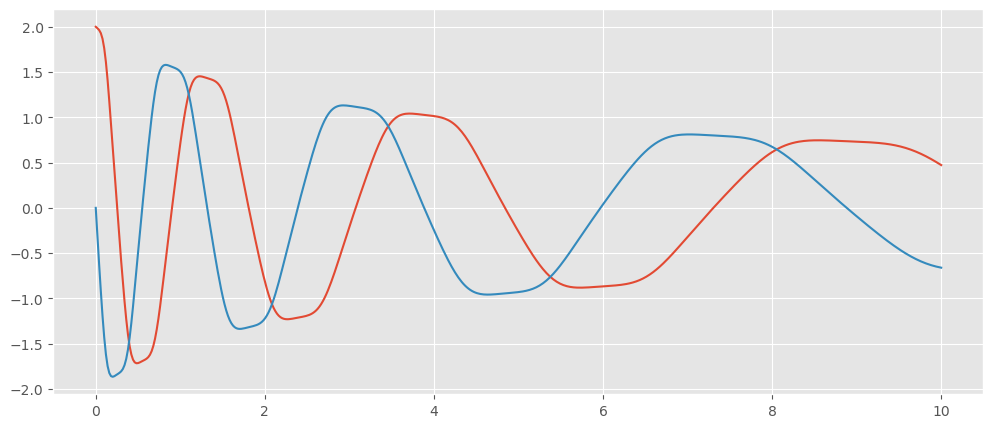

In [3]:
t_grid = jnp.linspace(0,t1,500)
x_vals = jax.vmap(sol.evaluate)(t_grid)

plt.figure(figsize=(12,5))
plt.plot(t_grid,x_vals[:,0])
plt.plot(t_grid,x_vals[:,1])

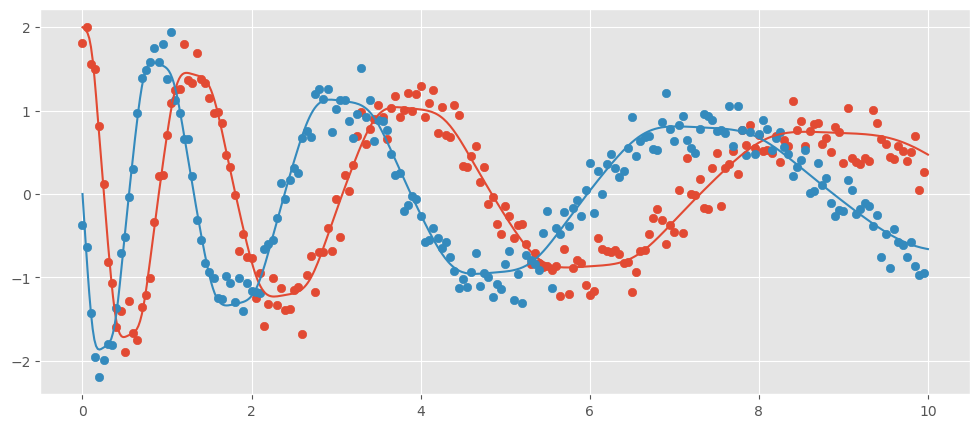

In [5]:
t_train = jnp.arange(0,t1,dt_train)
x_train_true = jax.vmap(sol.evaluate)(t_train)

noise_sigma = 0.2
x_train = x_train_true + noise_sigma * jax.random.normal(key(111),(x_train_true.shape))

plt.figure(figsize=(12,5))
plt.scatter(t_train,x_train[:,0])
plt.scatter(t_train,x_train[:,1])
plt.plot(t_grid,x_vals[:,0])
plt.plot(t_grid,x_vals[:,1])
plt.show()


In [6]:
true_theta = jnp.array(
    [[ 0.        ,  0.        ],
    [ 0.        , 0.    ],
    [0. ,  0.        ],
    [ 0.        ,  0.        ],
    [ 0.        ,  0.        ],
    [ 0.        ,  0.        ],
    [-0.1, -2.],
    [ 0.        ,  0.        ],
    [ 0.        ,  0.        ],
    [ 2., -0.1]])

In [7]:
noise_vals = jnp.array([0.02,0.04,0.08,0.16,0.32,0.64])
all_theta_errors = jnp.load('all_theta_errors.npy')
all_x_errors = jnp.load('all_x_errors.npy')

In [8]:
from pysindy import EnsembleOptimizer
from pysindy.differentiation import SmoothedFiniteDifference
import pysindy as ps
import numpy as np

In [9]:
library = ps.PolynomialLibrary(3)
optimizer = ps.STLSQ(0.09,5.)
diff_method = ps.SmoothedFiniteDifference()
ps_model = ps.SINDy(
    feature_library=library,
    optimizer=optimizer,
    differentiation_method=diff_method
    )

ps_errors = []
for noise_sigma in noise_vals:
    x_train = x_train_true + noise_sigma * jax.random.normal(key(123),(x_train_true.shape))
    ps_model.fit(np.array(x_train),np.array(t_train))
    theta = ps_model.coefficients().T

    ps_errors.append(jnp.linalg.norm(true_theta - theta)/jnp.linalg.norm(true_theta))
ps_errors = jnp.array(ps_errors)

In [10]:
odr_coef_error = jnp.array(loadtxt("coef_error.csv",delimiter = ','))
odr_x_error = jnp.array(loadtxt("x_error.csv",delimiter = ','))


odr_mean_x = jnp.mean(odr_coef_error[:-1],axis=0)
odr_mean_coef = jnp.mean(odr_x_error[:-1],axis=0)

odr_median_coef = jnp.median(odr_x_error[:-1],axis=0)

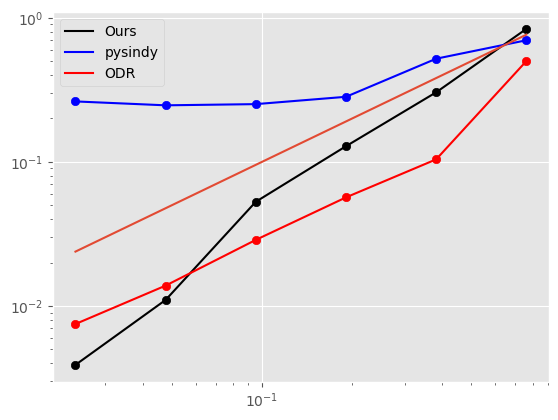

In [11]:
plt.plot(noise_vals/jnp.std(x_train_true),jnp.median(all_theta_errors,0),c='black',label = "Ours")
plt.scatter(noise_vals/jnp.std(x_train_true),jnp.median(all_theta_errors,0),c='black')

plt.plot(noise_vals/jnp.std(x_train_true),ps_errors,c='blue',label = 'pysindy')
plt.scatter(noise_vals/jnp.std(x_train_true),ps_errors,c='blue')

plt.plot(noise_vals/jnp.std(x_train_true),odr_median_coef,c='red',label = 'ODR')
plt.scatter(noise_vals/jnp.std(x_train_true),odr_median_coef,c='red')


plt.plot(noise_vals/jnp.std(x_train_true),noise_vals/jnp.std(x_train_true))


plt.xscale('log')
plt.yscale('log')


plt.legend()
plt.show()
